In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
import re
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")

### Función para leer los archivos de datos del grupo 01
Contienen diversos formatos, por lo que se manejará mediante un try-except.

In [2]:
def intentar_abrir_archivo_datos(path_archivo):

    df_archivo_telem_tab = pd.DataFrame([1,2,3], columns=["prueba"])
    df_archivo_telem_pc = pd.DataFrame([1,2,3], columns=["prueba"])
    df_archivo_telem_c = pd.DataFrame([1,2,3], columns=["prueba"])

    # Intentar leer el archivo con separador 'tab'
    try:
        #print("Leyendo con tab")
        df_archivo_telem_tab = pd.read_csv(path_archivo,
                                            sep="\t",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            ) 
    except:
        pass

    # Intentar leer el archivo con separador 'punto y coma'
    try:
        #print("Leyendo con ;")
        df_archivo_telem_pc = pd.read_csv(path_archivo,
                                            sep=";",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            #encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            )

    except:
        pass

    # Intentar leer el archivo con separador 'coma'
    try:
        #print("Leyendo con ,")
        df_archivo_telem_c = pd.read_csv(path_archivo,
                                            sep=",",
                                            #decimal=",",
                                            skiprows=11,
                                            #na_values="N/D",
                                            #encoding="utf-16",
                                            #on_bad_lines="skip",
                                            encoding_errors="ignore" 
                                            )

    except:
        pass



    if len(df_archivo_telem_tab.columns) > 1:
        df_archivo_telem = df_archivo_telem_tab.copy()
    elif len(df_archivo_telem_pc.columns) > 1:
        df_archivo_telem = df_archivo_telem_pc.copy()
    else:
        df_archivo_telem = df_archivo_telem_c.copy()

    return df_archivo_telem

### Lectura de los datos del grupo 01

In [3]:
mediciones_clientes_g1 = r"../data/mediciones_por_mes_g1"
archivos_mediciones_g1 = list(os.scandir(mediciones_clientes_g1))
columnas_extraer_g1 = ["Fecha","Demanda activa DEL","Demanda reactiva DEL"]

In [4]:
clientes_unicos_g1 = set()

for medicion in archivos_mediciones_g1:
    cliente = medicion.name.split('-')[1]
    clientes_unicos_g1.add(cliente)

print(f"Clientes único encontrados en la carpeta de mediciones del grupo uno: {len(clientes_unicos_g1)}")

Clientes único encontrados en la carpeta de mediciones del grupo uno: 313


In [5]:
# Diccionario para almacenar los clientes con sus respectivos datos
dict_dfs_clientes_g1 = {}

# Iterar sobre cada cliente
for cliente in tqdm(clientes_unicos_g1, desc="Procesando clientes del grupo 01"):
    datos_cliente = []
    # Iterar sobre cada archivo de medicion del grupo 01
    for medicion in archivos_mediciones_g1:
        if cliente == medicion.name.split("-")[1]:
            df_cliente = intentar_abrir_archivo_datos(f"{mediciones_clientes_g1}/{medicion.name}")
            datos_cliente.extend(df_cliente[columnas_extraer_g1].values)

    # Convertir a DataFrame los datos concatenados
    df_datos_anual_cliente = pd.DataFrame(datos_cliente, columns=columnas_extraer_g1)
    
    # Almacenar en el diccionario (Clave->Cliente   Valor->DataFrame)
    dict_dfs_clientes_g1[cliente]=df_datos_anual_cliente
    
    # Eliminar dataframe concatenado para liberar memoria
    del df_datos_anual_cliente
    #df_datos_anual_cliente.to_csv(f"mediciones_por_anio/g1_perfil_carga_anual-{cliente}-2023.csv", index=False)

Procesando clientes del grupo 01: 100%|██████████| 313/313 [00:45<00:00,  6.88it/s]


### Lectura de los datos del grupo 02

In [6]:
mediciones_clientes_g2 = "../data/mediciones_por_mes_g2"
archivos_mediciones_g2 = list(os.scandir(mediciones_clientes_g2))
columnas_extraer_g2 = ["Fecha", "AS (kWh)"]

In [7]:
print(f"Clientes único encontrados en la carpeta de mediciones del grupo uno: {len(archivos_mediciones_g2)}")

Clientes único encontrados en la carpeta de mediciones del grupo uno: 75


In [8]:
# Diccionario para almacenar los clientes con sus datos
dict_dfs_clientes_g2 = {}

# Iterar sobre cada cliente
for archivos_cliente in tqdm(archivos_mediciones_g2, desc="Procesando clientes del grupo 02"):
    nombre_cli = archivos_cliente.name.strip()
    df_concat = pd.DataFrame()

    # Obtener los archivos de las mediciones mensuales del cliente
    mediciones_mensuales_cliente = os.scandir(rf"{mediciones_clientes_g2}/{nombre_cli}")

    for medicion in mediciones_mensuales_cliente:
        medicion_mensual = pd.read_csv(rf"{mediciones_clientes_g2}/{nombre_cli}/{medicion.name}", sep=";", skiprows=2, encoding='ISO-8859-1')
        medicion_mensual = medicion_mensual[columnas_extraer_g2]
        df_concat = pd.concat([df_concat, medicion_mensual])

    # Almacenar en el diccionario (Clave->Cliente   Valor->DataFrame)
    dict_dfs_clientes_g2[nombre_cli] = df_concat
    
    # Eliminar dataframe concatenado para liberar memoria
    del df_concat
    #df_concat.to_csv(rf"mediciones_por_anio/g2_perfil_carga_anual-{nombre_cli}-2023.csv", index=False)

Procesando clientes del grupo 02: 100%|██████████| 75/75 [00:06<00:00, 11.50it/s]


### Creación de una tabla resúmen

In [9]:
# Funciones auxiliares para generar la tabla resumen
def potencia_o_energia(df):
    """Detecta si las columnas representan energía o potencia a partir de los nombres de columna."""
    
    cols = " ".join(map(str, df.columns)).lower()
    
    # Detectar si existen columnas de energía o potencia
    if 'kwh' in cols or '(kwh)' in cols or 'kw h' in cols:
        return 'Energía'
    if 'demanda' in cols or 'potencia' in cols or 'kw' in cols:
        return 'Potencias'
    
    return 'Desconocido'

def creat_tabla_resumen(dict_dfs, group_name=None):
    """Genera un DataFrame resumen con: cliente, intervalo_minutos, tipo_medicion, nro_registros."""
    rows = []
    for cliente, df in dict_dfs.items():
        df = df.reset_index(drop=True)
        df["Fecha"]=df["Fecha"].astype("string")
        df = df[~df["Fecha"].str.contains("Total")]
        try:
            primeros_minutos = int(str(df.loc[0,"Fecha"]).rsplit(':')[-1])
            segundos_minutos = int(str(df.loc[1,"Fecha"]).rsplit(':')[-1])
            if int(primeros_minutos) == 0 and segundos_minutos == 45:
                intervalo = abs(60-segundos_minutos)
            elif int(primeros_minutos) == 0 and segundos_minutos == 30:
                intervalo = abs(45-segundos_minutos)
            elif int(primeros_minutos) == 0 and segundos_minutos == 15:
                intervalo = abs(30-segundos_minutos)
            elif int(primeros_minutos) == 0 and segundos_minutos == 0:
                intervalo = abs(15-segundos_minutos)
            else:
                intervalo = abs(segundos_minutos-primeros_minutos)
                
            tipo = potencia_o_energia(df)
            nro = int(len(df))
        except Exception as e:
            print(f'Error procesando al cliente {cliente}')
            intervalo = np.nan
            tipo = 'Error'
            nro = 0
        rows.append({
            'cliente': cliente,
            'intervalo_minutos': intervalo,
            'tipo_medicion': tipo,
            'nro_registros': nro
        })
    return pd.DataFrame(rows)

# Generar resúmenes para los dos grupos ya cargados
summary_g1 = creat_tabla_resumen(dict_dfs_clientes_g1)
summary_g2 = creat_tabla_resumen(dict_dfs_clientes_g2)

# Concatenar y ordenar
summary_all = pd.concat([summary_g1, summary_g2], ignore_index=True)
summary_all['intervalo_minutos'] = summary_all['intervalo_minutos'].replace({np.nan: None})

# Guardar en variable global para uso posterior
resumen_mediciones_por_cliente = summary_all

print('Resumen generado. Filas:', len(summary_all))


Resumen generado. Filas: 388


In [10]:
resumen_mediciones_por_cliente

,cliente,intervalo_minutos,tipo_medicion,nro_registros
0,1648253,15,Potencias,26545
1,90000659,15,Potencias,28771
2,90002225,15,Potencias,26884
3,730664,15,Potencias,30109
4,90001352,15,Potencias,30891
...,...,...,...,...
383,SIGMAPLAST,15,Energía,35040
384,SINTOFIL,15,Energía,35040
385,SOCIEDAD INDUSTRIAL RELI CYRANO,15,Energía,35040
386,TEXTILES TEXSA,15,Energía,26592


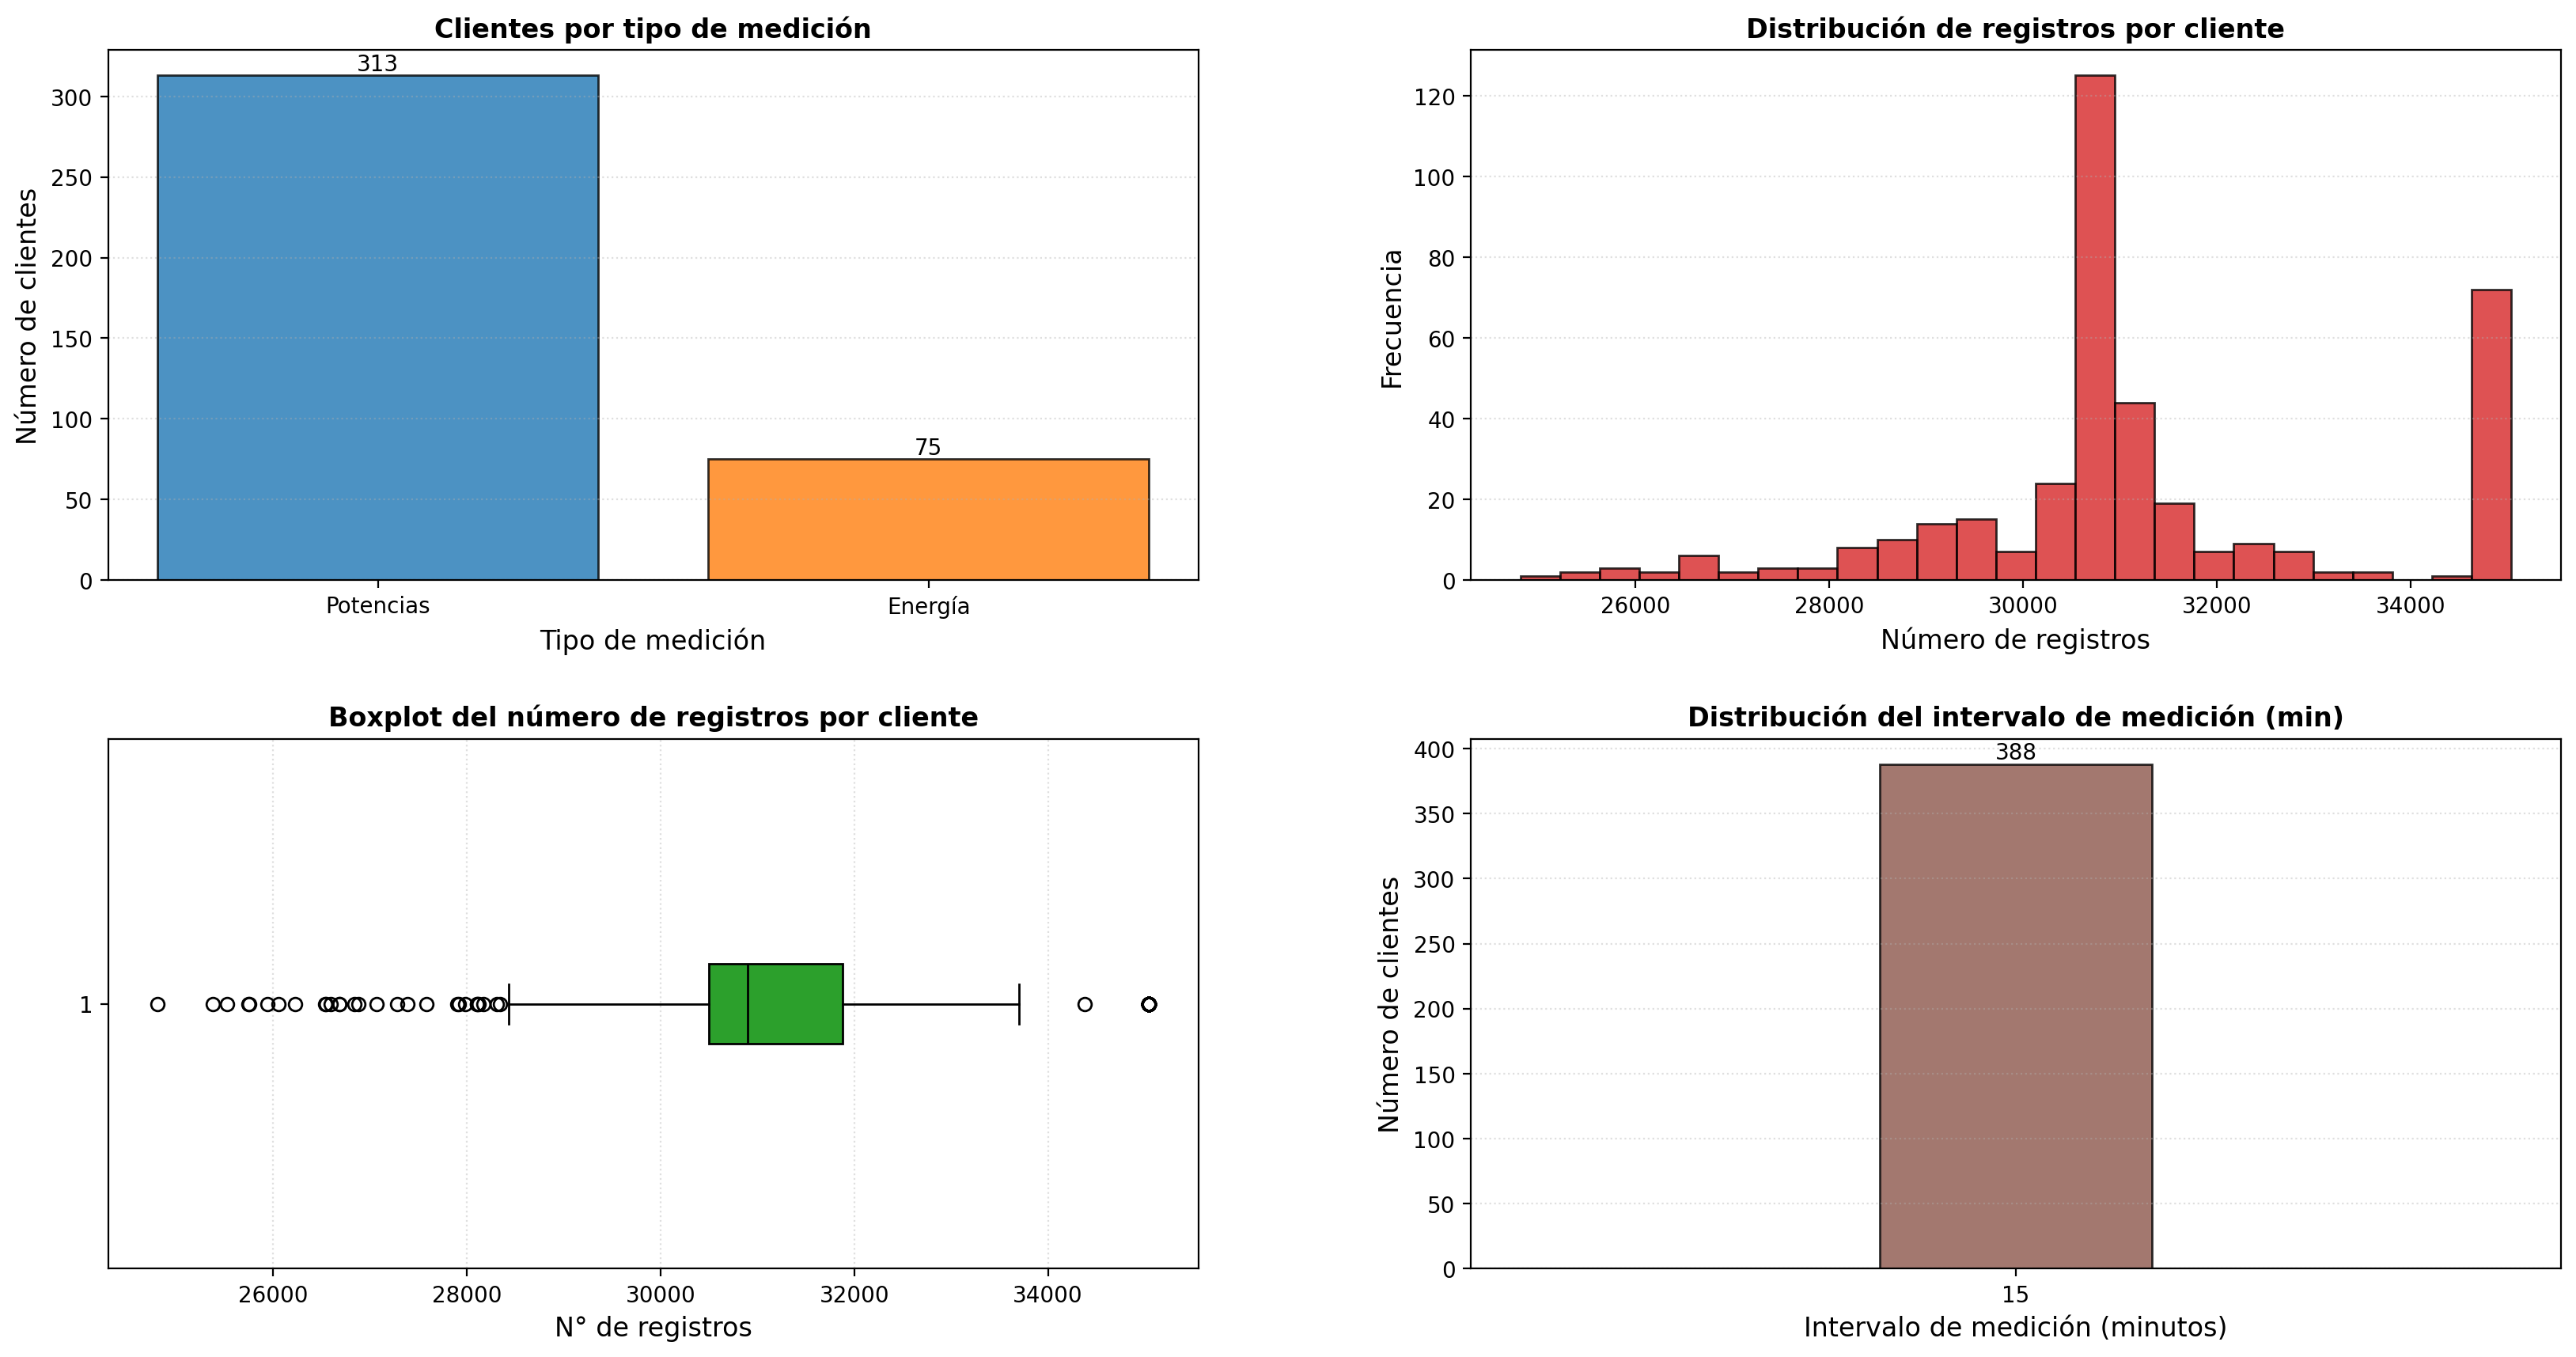

In [ ]:
# Colores elegantes
colores = plt.cm.tab10.colors

# Figura general
fig, axes = plt.subplots(2, 2, figsize=(20, 10), dpi=200)
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# -------------------- 1. Barplot tipo_medicion --------------------
ax = axes[0, 0]
conteo_tipo = resumen_mediciones_por_cliente['tipo_medicion'].value_counts()
bars = ax.bar(conteo_tipo.index.astype(str), conteo_tipo.values, color=colores,edgecolor='black', alpha=0.8)

ax.set_title('Clientes por tipo de medición', fontsize=12, weight='bold')
ax.set_xlabel('Tipo de medición', fontsize=12)
ax.set_ylabel('Número de clientes', fontsize=12)
ax.grid(axis='y', linestyle=':', alpha=0.4)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f"{int(bar.get_height())}", ha='center', va='bottom', fontsize=10)

# -------------------- 2. Histograma nro_registros --------------------
ax = axes[0, 1]
ax.hist(resumen_mediciones_por_cliente['nro_registros'].dropna(),
        bins=25, edgecolor='black', alpha=0.8, color=colores[3])
ax.set_title('Distribución de registros por cliente', fontsize=12, weight='bold')
ax.set_xlabel('Número de registros', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.grid(axis='y', linestyle=':', alpha=0.4)

# -------------------- 3. Boxplot horizontal --------------------
ax = axes[1, 0]
ax.boxplot(resumen_mediciones_por_cliente['nro_registros'].dropna(),
           vert=False,
           patch_artist=True,
           boxprops=dict(facecolor=colores[2], color='black'),
           medianprops=dict(color='black'))
ax.set_title('Boxplot del número de registros por cliente', fontsize=12, weight='bold')
ax.set_xlabel('N° de registros', fontsize=12)
ax.grid(axis='x', linestyle=':', alpha=0.4)

# -------------------- 4. Barplot de intervalo (barra realmente más delgada y centrada) --------------------
ax = axes[1, 1]
conteo_intervalo = resumen_mediciones_por_cliente['intervalo_minutos'].value_counts()

# Crear posiciones manuales (por si luego hay más intervalos)
x_positions = np.arange(len(conteo_intervalo))

# Barra más delgada y centrada
bars_intervalo = ax.bar(x_positions,
                        conteo_intervalo.values,
                        width=0.3,       # ANCHO REAL DE LA BARRA
                        color=colores[5],
                        align='center',
                        edgecolor='black', alpha=0.8)

# Etiquetas y estilo
ax.set_title('Distribución del intervalo de medición (min)', fontsize=12, weight='bold')
ax.set_xlabel('Intervalo de medición (minutos)', fontsize=12)
ax.set_ylabel('Número de clientes', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels(conteo_intervalo.index.astype(str))

# Ajuste del eje X para evitar que la barra se vea gruesa
ax.set_xlim(-0.6, len(x_positions) - 0.4)

ax.grid(axis='y', linestyle=':', alpha=0.4)

# Etiquetas sobre barra
for bar in bars_intervalo:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f"{int(bar.get_height())}",
            ha='center', va='bottom', fontsize=10)

### Análisis de Calidad de Datos

In [44]:
IDEAL_REG_15MIN = 35040  # registros ideales (15 min * 24h * 365 días)
#plt.style.use('seaborn-v0_8-whitegrid')

# -----------------------------
# FUNCIONES AUXILIARES
# -----------------------------

def contar_coma_miles_en_df(df, columnas_numericas):
    """Cuenta registros que contienen coma como separador de miles."""
    if not columnas_numericas:
        return 0
    regex = re.compile(r'^\s*\d{1,3}(,\d{3})+(\.\d+)?\s*$')
    mask_total = pd.Series(False, index=df.index)
    for col in columnas_numericas:
        if col not in df.columns:
            continue
        s = df[col].astype(str)
        mask_col = s.str.match(regex, na=False)
        mask_total |= mask_col
    return int(mask_total.sum())

def clasificar_formato_fecha(serie_fecha):
    """Clasifica los formatos de fecha (cadena)."""
    serie_str = serie_fecha.astype(str).str.strip()
    parte_fecha = serie_str.str.split().str[0]
    formato = pd.Series('Sin identificar', index=parte_fecha.index)

    reglas = {
        'YYYY-MM-DD': r'^\d{4}-\d{1,2}-\d{1,2}$',
        'YYYY/MM/DD': r'^\d{4}/\d{1,2}/\d{1,2}$',
        'DD-MM-YYYY': r'^\d{1,2}-\d{1,2}-\d{4}$',
        'DD/MM/YYYY': r'^\d{1,2}/\d{1,2}/\d{4}$',
    }

    for nombre, patron in reglas.items():
        formato[parte_fecha.str.match(patron, na=False)] = nombre

    # Si ya es datetime64
    #if np.issubdtype(serie_fecha.dtype, np.datetime64):
        #formato[:] = 'datetime64'

    return formato

def total_nulls_en_df(df, columnas_objetivo):
    """Cuenta los valores NaN (0 es válido)."""
    cols = [c for c in columnas_objetivo if c in df.columns]
    if not cols:
        return 0
    return int(df[cols].isna().sum().sum())

# -----------------------------
# FUNCIÓN PRINCIPAL
# -----------------------------

def plot_verificacion_calidad_2x2(dict_dfs_clientes_g1, dict_dfs_clientes_g2):
    """
    Genera una figura 2x2 con:
      (1) Distribución de formatos de fecha (%)
      (2) Registros con coma como separador de miles
      (3) Clientes por intervalo de completitud (70–85 %, 85–100 %)
      (4) Registros NULOS (NaN)
    """
    colores = plt.cm.tab20.colors
    colores2 = plt.cm.tab10.colors
    edge_kwargs = dict(edgecolor='black', linewidth=0.8)

    # Variables acumuladoras
    formatos_counter = {}
    nulos_g1_total = nulos_g2_total = 0
    coma_miles_g1_total = coma_miles_g2_total = 0
    bin_7085 = bin_85100 = 0

    # --- Grupo 1 (potencias) ---
    cols_g1 = ['Demanda activa DEL', 'Demanda reactiva DEL']
    for cliente, df in dict_dfs_clientes_g1.items():
        if 'Fecha' in df.columns:
            formatos = clasificar_formato_fecha(df['Fecha'])
            conteo = formatos.value_counts()
            for k, v in conteo.items():
                formatos_counter[k] = formatos_counter.get(k, 0) + int(v)
        coma_miles_g1_total += contar_coma_miles_en_df(df, cols_g1)
        nulos_g1_total += total_nulls_en_df(df, cols_g1)
        pct = len(df) / IDEAL_REG_15MIN
        if 0.70 <= pct < 0.85:
            bin_7085 += 1
        elif 0.85 <= pct <= 1.00:
            bin_85100 += 1
        else:
            print(f"revisar cliente {cliente}")

    # --- Grupo 2 (energía) ---
    cols_g2 = ['AS (kWh)']
    for cliente, df in dict_dfs_clientes_g2.items():
        if 'Fecha' in df.columns:
            df["Fecha"]=df["Fecha"].astype("string")
            df = df[~df["Fecha"].str.contains("Total")]
            formatos = clasificar_formato_fecha(df['Fecha'])
            conteo = formatos.value_counts()
            for k, v in conteo.items():
                formatos_counter[k] = formatos_counter.get(k, 0) + int(v)
        coma_miles_g2_total += contar_coma_miles_en_df(df, cols_g2)
        nulos_g2_total += total_nulls_en_df(df, cols_g2)
        pct = len(df) / IDEAL_REG_15MIN
        if 0.70 <= pct < 0.85:
            bin_7085 += 1
        elif 0.85 <= pct <= 1.00:
            bin_85100 += 1
        else:
            print(f"revisar cliente {cliente}")
    # --- Normalización a porcentajes ---
    total_registros = sum(formatos_counter.values())
    formatos_labels = list(formatos_counter.keys())
    formatos_vals = [(v / total_registros) * 100 for v in formatos_counter.values()]

    # -------------------------
    # FIGURA 2x2
    # -------------------------
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=200)
    plt.subplots_adjust(hspace=0.3, wspace=0.25)
    ax1, ax2 = axes[0, 0], axes[0, 1]
    ax3, ax4 = axes[1, 0], axes[1, 1]

    # (1) Formatos de fecha (%)
    ax1.bar(formatos_labels, formatos_vals, color=colores2[:len(formatos_labels)], width=0.6, **edge_kwargs)
    ax1.set_title('Distribución de formatos de fecha', fontsize=12, weight='bold')
    ax1.set_ylabel('Porcentaje de registros (%)')
    ax1.tick_params(axis='x', rotation=25)
    ax1.grid(axis='y', linestyle=':', alpha=0.4)
    for i, v in enumerate(formatos_vals):
        ax1.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9)

    # (2) Coma como separador de miles
    vals2 = [coma_miles_g1_total, coma_miles_g2_total]
    ax2.bar(['Grupo01 (Potencias)', 'Grupo02 (Energía)'], vals2, color=[colores[0], colores2[5]], width=0.5, **edge_kwargs)
    ax2.set_title('Registros con coma como separador de miles', fontsize=12, weight='bold')
    ax2.set_ylabel('Número de registros')
    ax2.grid(axis='y', linestyle=':', alpha=0.4)
    for i, v in enumerate(vals2):
        ax2.text(i, v + max(v * 0.02, 100), str(v), ha='center', fontsize=9)

    # (3) Completitud (70–85%, 85–100%)
    vals3 = [bin_7085, bin_85100]
    ax3.bar(['70%-85%', '85%-100%'], vals3, color=[colores[-1], colores[-3]], width=0.5, **edge_kwargs)
    ax3.set_title('Clientes por intervalo de completitud (sobre 35 040)', fontsize=12, weight='bold')
    ax3.set_ylabel('Número de clientes')
    ax3.grid(axis='y', linestyle=':', alpha=0.4)
    for i, v in enumerate(vals3):
        ax3.text(i, v + 6, str(v), ha='center', fontsize=9)

    # (4) Registros NULOS (NaN)
    vals4 = [nulos_g1_total, nulos_g2_total]
    ax4.bar(['Grupo01 (Potencias)', 'Grupo02 (Energía)'], vals4, color=[colores[-5], colores[5]], width=0.5, **edge_kwargs)
    ax4.set_title('Registros nulos (NaN o sin valor)', fontsize=12, weight='bold')
    ax4.set_ylabel('Número de registros')
    ax4.grid(axis='y', linestyle=':', alpha=0.4)
    for i, v in enumerate(vals4):
        ax4.text(i, v + max(v * 0.02, 50), str(v), ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()


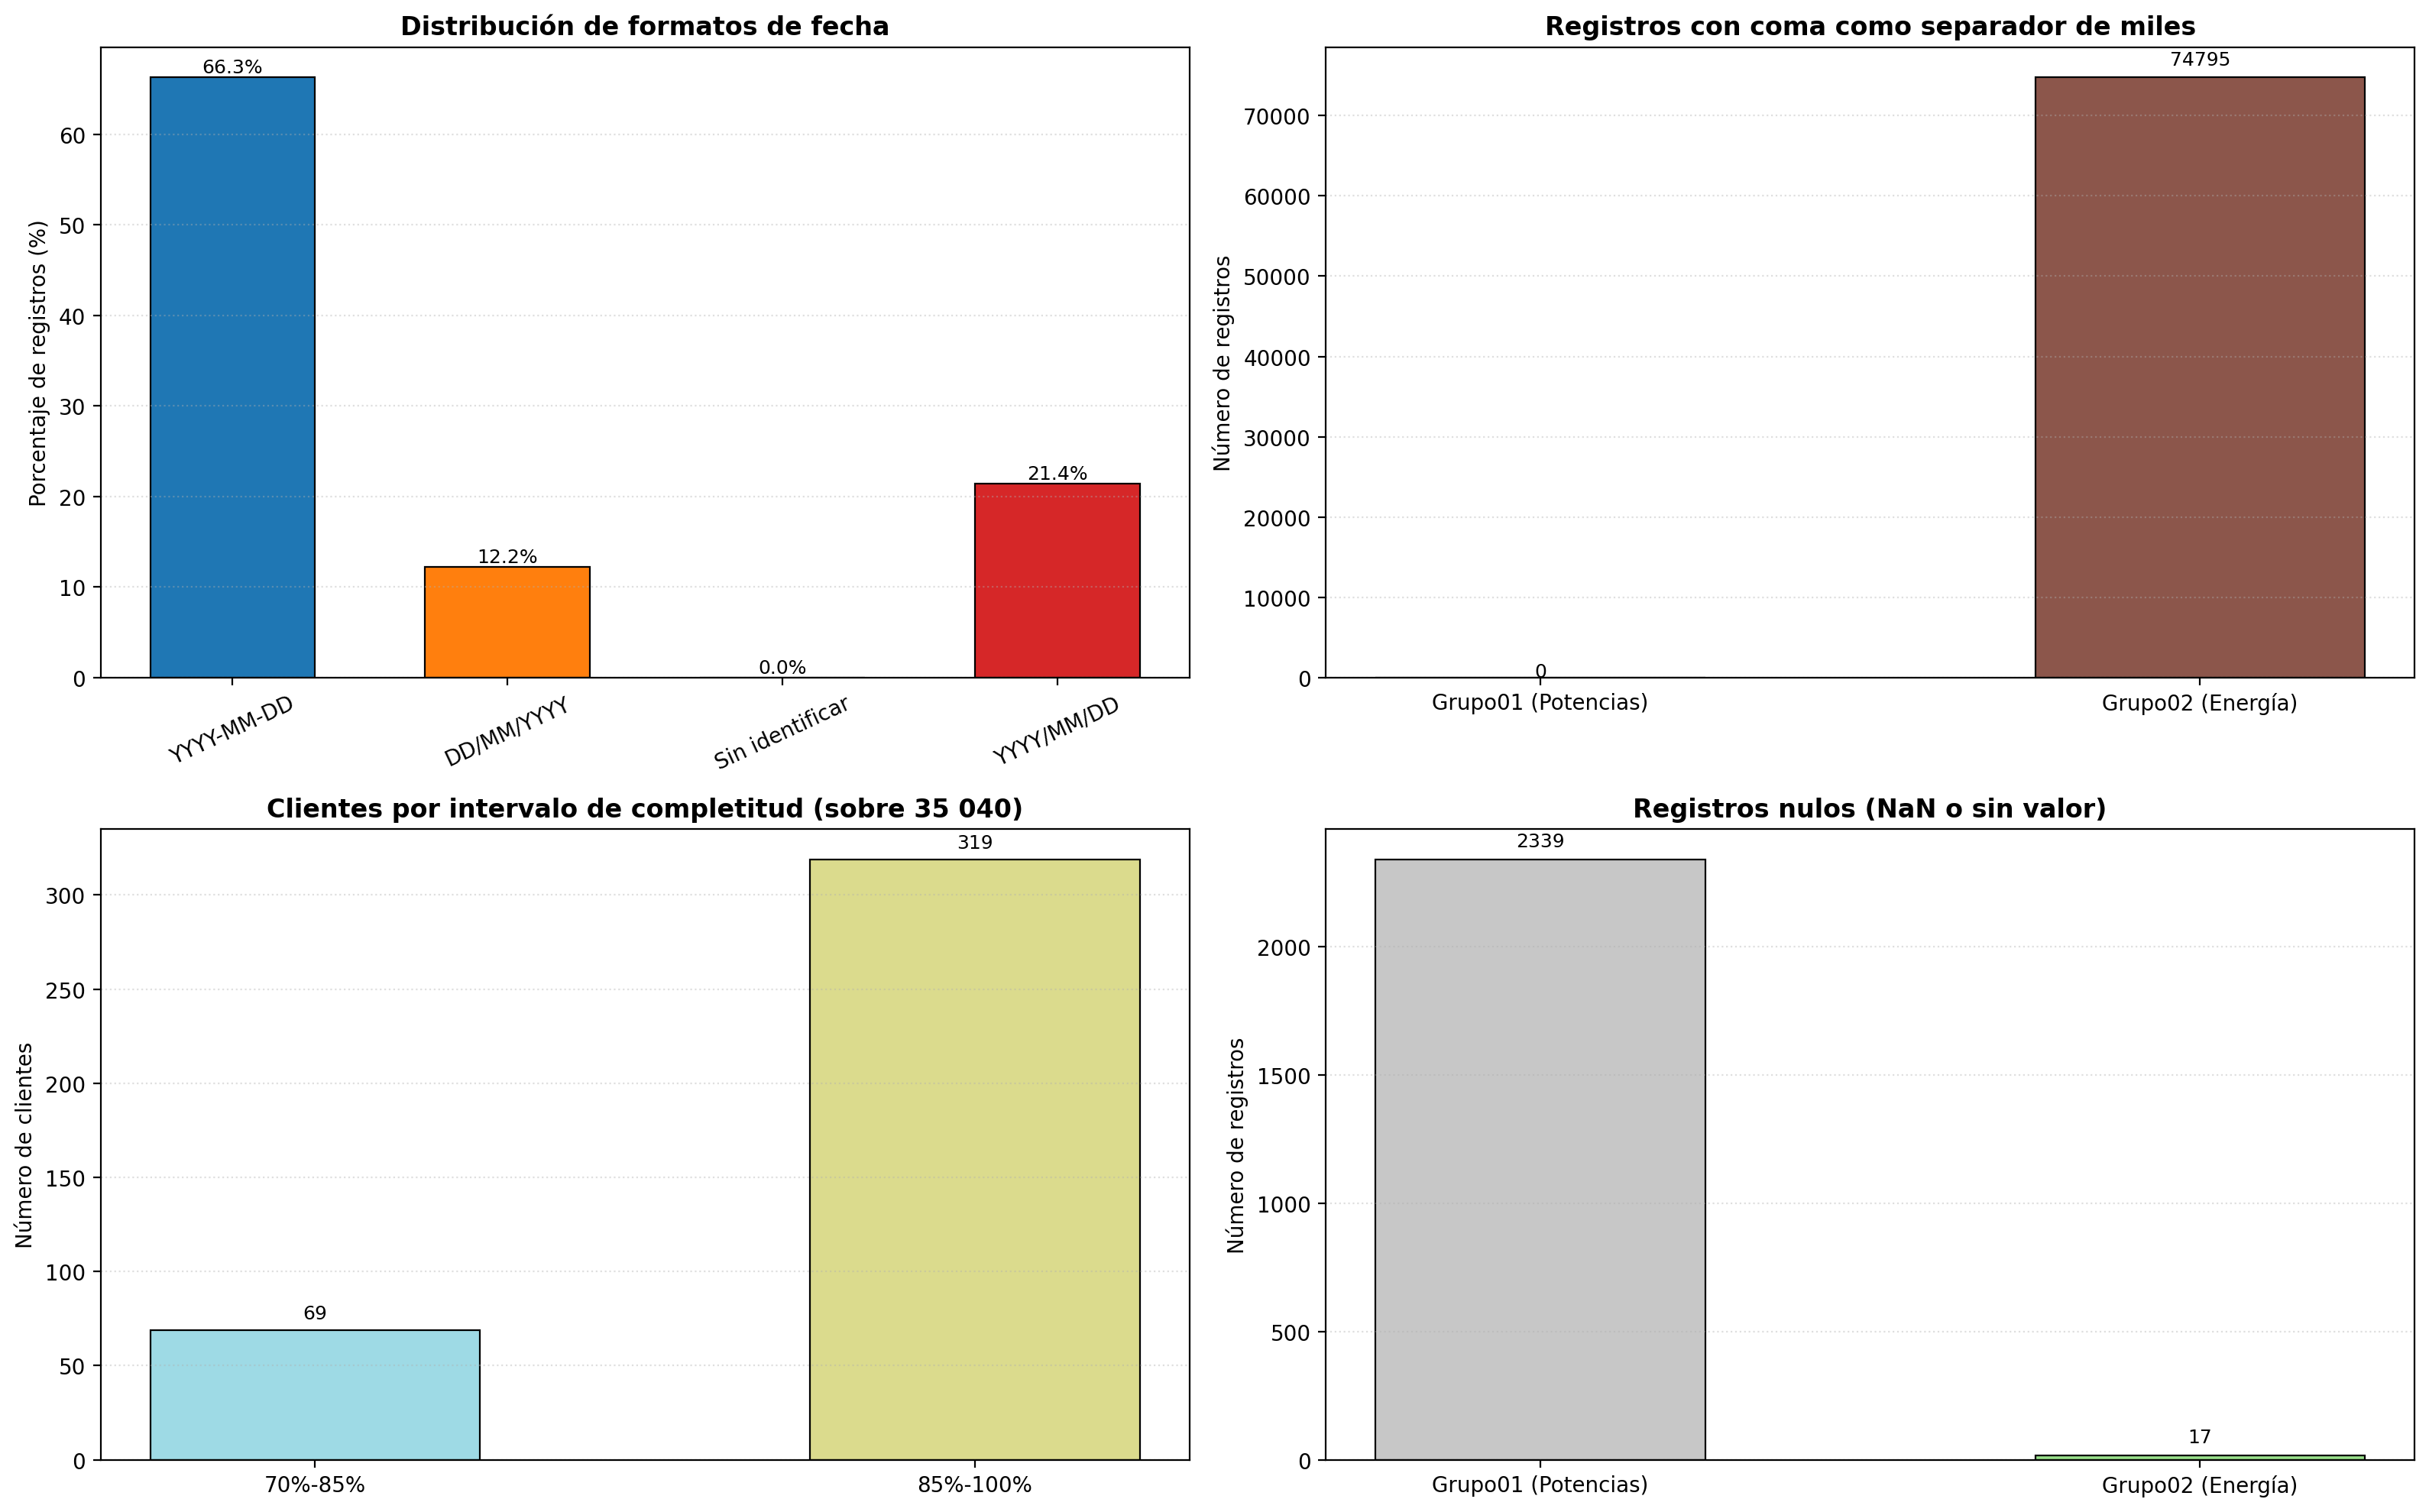

In [45]:
plot_verificacion_calidad_2x2(dict_dfs_clientes_g1, dict_dfs_clientes_g2)